# Assignment 2 Question 2 - Emotion Analysis using SVM and K-Means Clustering

## Objective
The objective of this assignment is to develop an understanding of emotion recognition in text using Support Vector Machines (SVM) for classification and K-Means clustering for pattern discovery. This assignment aims to provide insight into both supervised and unsupervised learning techniques in Natural Language Processing (NLP).

## Key Components
1. **Supervised Learning with SVM:**
   - Utilize Support Vector Machines (SVM), a powerful supervised learning algorithm, for text classification.
   - Train the SVM model to recognize and classify emotions in text data.
   - Explore techniques for feature extraction and representation to effectively capture the linguistic nuances associated with different emotions.

2. **Unsupervised Learning with K-Means Clustering:**
   - Apply K-Means clustering, an unsupervised learning algorithm, to discover patterns in text data.
   - Cluster similar textual expressions based on their underlying characteristics, without the need for labeled training data.
   - Investigate the effectiveness of K-Means in identifying natural groupings or clusters of text associated with distinct emotional states.

## Expected Outcomes
- Gain proficiency in implementing supervised learning techniques for text classification using SVM.
- Understand the principles and applications of unsupervised learning in NLP through K-Means clustering.
- Develop insights into the challenges and considerations involved in emotion recognition in text data.
- Acquire practical skills in feature engineering, model training, and evaluation in the context of NLP tasks.

## Learning Goals
- Grasp the concepts and methodologies underlying SVM and K-Means algorithms.
- Gain hands-on experience in applying these algorithms to real-world text data for emotion recognition.
- Analyze and interpret the results of both supervised and unsupervised learning approaches for emotion detection in text.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
import json
import contractions
import nltk

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm

nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
np.random.seed(42)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\abdem\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abdem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Preparation

## Objective
The objective of this section is to prepare the EmotionLines dataset for emotion recognition tasks. This involves loading and familiarizing oneself with the dataset, conducting text preprocessing to clean and standardize the text data, and transforming the textual content into numerical representations using TF-IDF (Term Frequency-Inverse Document Frequency) for further analysis and modeling.

## Steps to Accomplish
1. **Load and Familiarize with Dataset:**
   - Load the EmotionLines dataset into the environment.
   - Familiarize oneself with the structure, format, and contents of the dataset, including available features and target labels.
   - Understand the distribution of emotions/categories within the dataset.

2. **Text Preprocessing:**
   - Tokenization: Splitting the text into individual words or tokens.
   - Stemming/Lemmatization: Reducing words to their base or root form to normalize the text.
   - Removing Stop Words: Eliminating common words (e.g., 'the', 'is', 'and') that do not contribute significantly to the meaning of the text.

3. **Transform Text into Numerical Representations using TF-IDF:**
   - TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical representation technique that quantifies the importance of a term in a document relative to a collection of documents.
   - Calculate TF-IDF scores for each term in the text corpus, considering both the term's frequency in the document (TF) and its rarity in the entire corpus (IDF).
   - Transform the preprocessed textual data into TF-IDF vectors, where each document is represented by a vector of TF-IDF scores for each term.

In [2]:
file_paths = ['./EmotionLines/Friends/friends_train.json', './EmotionLines/Friends/friends_test.json', './EmotionLines/Friends/friends_dev.json']
dataset_dict = {}

for file_path in file_paths:
    data_type = file_path.split('/')[-1].split('_')[-1].split('.')[0]

    with open(file_path, 'r') as file:
        json_data = json.load(file)

    dataset_dict[data_type] = pd.concat([pd.DataFrame(json_data[idx]) for idx in range(len(json_data))], ignore_index=True)

print(dataset_dict.keys())
print(f'Train Shape: {dataset_dict["train"].shape}, Dev Shape: {dataset_dict["dev"].shape}, Test Shape: {dataset_dict["test"].shape}')

dataset_dict['train']

dict_keys(['train', 'test', 'dev'])
Train Shape: (10561, 4), Dev Shape: (1178, 4), Test Shape: (2764, 4)


,speaker,utterance,emotion,annotation
0,Chandler,also I was the point person on my companys tr...,neutral,4100000
1,The Interviewer,You mustve had your hands full.,neutral,5000000
2,Chandler,That I did. That I did.,neutral,5000000
3,The Interviewer,So lets talk a little bit about your duties.,neutral,5000000
4,Chandler,My duties? All right.,surprise,2000030
...,...,...,...,...
10556,Chandler,You or me?,neutral,3000011
10557,Ross,"I got it. Uh, Joey, women don't have Adam's ap...",non-neutral,2100011
10558,Joey,"You guys are messing with me, right?",surprise,0000050
10559,All,Yeah.,neutral,4000010


In [3]:
dataset_dict['train']['utterance'].isna().sum()

0

In [4]:
dataset_dict['train']['processed_text'] = dataset_dict['train']['utterance'].str.replace('\x92', '\'').str.lower().apply(lambda row: contractions.fix(row))
dataset_dict['dev']['processed_text'] = dataset_dict['dev']['utterance'].str.replace('\x92', '\'').str.lower().apply(lambda row: contractions.fix(row))
dataset_dict['test']['processed_text'] = dataset_dict['test']['utterance'].str.replace('\x92', '\'').str.lower().apply(lambda row: contractions.fix(row))

In [5]:
dataset_dict['train']

,speaker,utterance,emotion,annotation,processed_text
0,Chandler,also I was the point person on my companys tr...,neutral,4100000,also i was the point person on my company's tr...
1,The Interviewer,You mustve had your hands full.,neutral,5000000,you must have had your hands full.
2,Chandler,That I did. That I did.,neutral,5000000,that i did. that i did.
3,The Interviewer,So lets talk a little bit about your duties.,neutral,5000000,so let us talk a little bit about your duties.
4,Chandler,My duties? All right.,surprise,2000030,my duties? all right.
...,...,...,...,...,...
10556,Chandler,You or me?,neutral,3000011,you or me?
10557,Ross,"I got it. Uh, Joey, women don't have Adam's ap...",non-neutral,2100011,"i got it. uh, joey, women do not have adam's a..."
10558,Joey,"You guys are messing with me, right?",surprise,0000050,"you guys are messing with me, right?"
10559,All,Yeah.,neutral,4000010,yeah.


In [6]:
dataset_dict['train']['processed_text'].isna().sum()

0

In [7]:
dataset_dict['train']['processed_text'] = dataset_dict['train']['processed_text'].apply(lambda row: word_tokenize(row))
dataset_dict['dev']['processed_text'] = dataset_dict['dev']['processed_text'].apply(lambda row: word_tokenize(row))
dataset_dict['test']['processed_text'] = dataset_dict['test']['processed_text'].apply(lambda row: word_tokenize(row))

In [8]:
dataset_dict['train']

,speaker,utterance,emotion,annotation,processed_text
0,Chandler,also I was the point person on my companys tr...,neutral,4100000,"[also, i, was, the, point, person, on, my, com..."
1,The Interviewer,You mustve had your hands full.,neutral,5000000,"[you, must, have, had, your, hands, full, .]"
2,Chandler,That I did. That I did.,neutral,5000000,"[that, i, did, ., that, i, did, .]"
3,The Interviewer,So lets talk a little bit about your duties.,neutral,5000000,"[so, let, us, talk, a, little, bit, about, you..."
4,Chandler,My duties? All right.,surprise,2000030,"[my, duties, ?, all, right, .]"
...,...,...,...,...,...
10556,Chandler,You or me?,neutral,3000011,"[you, or, me, ?]"
10557,Ross,"I got it. Uh, Joey, women don't have Adam's ap...",non-neutral,2100011,"[i, got, it, ., uh, ,, joey, ,, women, do, not..."
10558,Joey,"You guys are messing with me, right?",surprise,0000050,"[you, guys, are, messing, with, me, ,, right, ?]"
10559,All,Yeah.,neutral,4000010,"[yeah, .]"


In [9]:
dataset_dict['train']['processed_text'].isna().sum()

0

In [10]:
def remove_stop_words(sentence_tokens: list) -> list:
    filtered_tokens = [word for word in sentence_tokens if not word in set(stopwords.words('english'))]
    return filtered_tokens if len(filtered_tokens) > 0 else []

dataset_dict['train']['stop_words_removed_text'] = dataset_dict['train']['processed_text'].apply(lambda row: remove_stop_words(row))
dataset_dict['dev']['stop_words_removed_text'] = dataset_dict['dev']['processed_text'].apply(lambda row: remove_stop_words(row))
dataset_dict['test']['stop_words_removed_text'] = dataset_dict['test']['processed_text'].apply(lambda row: remove_stop_words(row))

In [11]:
dataset_dict['train']

,speaker,utterance,emotion,annotation,processed_text,stop_words_removed_text
0,Chandler,also I was the point person on my companys tr...,neutral,4100000,"[also, i, was, the, point, person, on, my, com...","[also, point, person, company, 's, transition,..."
1,The Interviewer,You mustve had your hands full.,neutral,5000000,"[you, must, have, had, your, hands, full, .]","[must, hands, full, .]"
2,Chandler,That I did. That I did.,neutral,5000000,"[that, i, did, ., that, i, did, .]","[., .]"
3,The Interviewer,So lets talk a little bit about your duties.,neutral,5000000,"[so, let, us, talk, a, little, bit, about, you...","[let, us, talk, little, bit, duties, .]"
4,Chandler,My duties? All right.,surprise,2000030,"[my, duties, ?, all, right, .]","[duties, ?, right, .]"
...,...,...,...,...,...,...
10556,Chandler,You or me?,neutral,3000011,"[you, or, me, ?]",[?]
10557,Ross,"I got it. Uh, Joey, women don't have Adam's ap...",non-neutral,2100011,"[i, got, it, ., uh, ,, joey, ,, women, do, not...","[got, ., uh, ,, joey, ,, women, adam, 's, appl..."
10558,Joey,"You guys are messing with me, right?",surprise,0000050,"[you, guys, are, messing, with, me, ,, right, ?]","[guys, messing, ,, right, ?]"
10559,All,Yeah.,neutral,4000010,"[yeah, .]","[yeah, .]"


In [12]:
def lemmatize_sentences(sentence_tokens: list, lemmatizer_object: WordNetLemmatizer) -> list:
    if len(sentence_tokens) == 0:
        return np.nan

    tag_dict = {
        'J': wordnet.ADJ, 'V': wordnet.VERB, 'N': wordnet.NOUN, 'R': wordnet.ADV}

    parts_of_speech_tags = nltk.pos_tag(sentence_tokens)
    wordnet_tags = list(map(lambda tokens_tag: (tokens_tag[0], tag_dict.get(tokens_tag[1][0])), parts_of_speech_tags))

    return [lemmatizer_object.lemmatize(word, tag) if tag is not None else word for word, tag in wordnet_tags]

In [13]:
lemmatizer_object = WordNetLemmatizer()

dataset_dict['train']['processed_text'] = dataset_dict['train']['processed_text'].apply(lambda row: lemmatize_sentences(row, lemmatizer_object))
dataset_dict['dev']['processed_text'] = dataset_dict['dev']['processed_text'].apply(lambda row: lemmatize_sentences(row, lemmatizer_object))
dataset_dict['test']['processed_text'] = dataset_dict['test']['processed_text'].apply(lambda row: lemmatize_sentences(row, lemmatizer_object))

dataset_dict['train'] = dataset_dict['train'].dropna(subset=['processed_text'])
dataset_dict['dev'] = dataset_dict['dev'].dropna(subset=['processed_text'])
dataset_dict['test'] = dataset_dict['test'].dropna(subset=['processed_text'])

In [14]:
dataset_dict['train']['processed_text'].isna().sum()

0

In [15]:
dataset_dict['train']['stop_words_removed_text'] = dataset_dict['train']['stop_words_removed_text'].apply(lambda row: lemmatize_sentences(row, lemmatizer_object))
dataset_dict['dev']['stop_words_removed_text'] = dataset_dict['dev']['stop_words_removed_text'].apply(lambda row: lemmatize_sentences(row, lemmatizer_object))
dataset_dict['test']['stop_words_removed_text'] = dataset_dict['test']['stop_words_removed_text'].apply(lambda row: lemmatize_sentences(row, lemmatizer_object))

In [16]:
dataset_dict['train']['stop_words_removed_text']

0        [also, point, person, company, 's, transition,...
1                                    [must, hand, full, .]
2                                                   [., .]
3                    [let, us, talk, little, bit, duty, .]
4                                      [duty, ?, right, .]
                               ...                        
10556                                                  [?]
10557    [got, ., uh, ,, joey, ,, woman, adam, 's, appl...
10558                             [guy, mess, ,, right, ?]
10559                                            [yeah, .]
10560    [good, one, ., second, ,, like, ,, ``, whoa, ....
Name: stop_words_removed_text, Length: 10561, dtype: object

In [17]:
dataset_dict['train']['stop_words_removed_text'].isna().sum()

40

In [18]:
dataset_dict['train']

,speaker,utterance,emotion,annotation,processed_text,stop_words_removed_text
0,Chandler,also I was the point person on my companys tr...,neutral,4100000,"[also, i, be, the, point, person, on, my, comp...","[also, point, person, company, 's, transition,..."
1,The Interviewer,You mustve had your hands full.,neutral,5000000,"[you, must, have, have, your, hand, full, .]","[must, hand, full, .]"
2,Chandler,That I did. That I did.,neutral,5000000,"[that, i, do, ., that, i, do, .]","[., .]"
3,The Interviewer,So lets talk a little bit about your duties.,neutral,5000000,"[so, let, us, talk, a, little, bit, about, you...","[let, us, talk, little, bit, duty, .]"
4,Chandler,My duties? All right.,surprise,2000030,"[my, duty, ?, all, right, .]","[duty, ?, right, .]"
...,...,...,...,...,...,...
10556,Chandler,You or me?,neutral,3000011,"[you, or, me, ?]",[?]
10557,Ross,"I got it. Uh, Joey, women don't have Adam's ap...",non-neutral,2100011,"[i, get, it, ., uh, ,, joey, ,, woman, do, not...","[got, ., uh, ,, joey, ,, woman, adam, 's, appl..."
10558,Joey,"You guys are messing with me, right?",surprise,0000050,"[you, guy, be, mess, with, me, ,, right, ?]","[guy, mess, ,, right, ?]"
10559,All,Yeah.,neutral,4000010,"[yeah, .]","[yeah, .]"


In [19]:
dataset_dict['train']['processed_text'].isna().sum()

0

In [20]:
tfidf_vectorizer_processed = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)
tfidf_vectorizer_processed.fit(dataset_dict['train']['processed_text'])

X_train_processed = tfidf_vectorizer_processed.transform(dataset_dict['train']['processed_text'])
X_val_processed = tfidf_vectorizer_processed.transform(dataset_dict['dev']['processed_text'])
X_test_processed = tfidf_vectorizer_processed.transform(dataset_dict['test']['processed_text'])

encoder_processed = LabelEncoder()

y_train_processed = encoder_processed.fit_transform(dataset_dict['train']['emotion'])
y_val_processed = encoder_processed.fit_transform(dataset_dict['dev']['emotion'])
y_test_processed = encoder_processed.fit_transform(dataset_dict['test']['emotion'])

print(X_train_processed)

  (0, 4543)	0.35883951804744085
  (0, 4483)	0.10219457386495641
  (0, 4399)	0.217756749032805
  (0, 4315)	0.3118747322227441
  (0, 3424)	0.2858893625250043
  (0, 3325)	0.2689449084931
  (0, 3143)	0.1522982570413118
  (0, 2930)	0.1421833305241925
  (0, 2450)	0.35883951804744085
  (0, 2175)	0.08276215315353515
  (0, 1910)	0.35883951804744085
  (0, 1779)	0.2086087485358831
  (0, 1019)	0.3176536815091473
  (0, 508)	0.07080530511138884
  (0, 281)	0.26568294211366755
  (0, 50)	0.06058572619260656
  (0, 31)	0.17480725695336652
  (1, 5006)	0.28863666500226254
  (1, 4997)	0.15040769139150895
  (1, 2925)	0.4569578169615289
  (1, 2016)	0.44535250541511656
  (1, 1987)	0.43565366050936105
  (1, 1791)	0.5344722771405238
  (1, 50)	0.1070624793188457
  (2, 4390)	0.6113212991863248
  :	:
  (10558, 4909)	0.34492999920570133
  (10558, 3702)	0.34276003146038214
  (10558, 2796)	0.6343074181805425
  (10558, 2755)	0.3065724168384326
  (10558, 1962)	0.3824987685597042
  (10558, 508)	0.1570968918955931
  (1055

In [21]:
y_train_processed

array([4, 4, 4, ..., 7, 4, 5])

In [22]:
train_stop = dataset_dict['train'].dropna(subset=['stop_words_removed_text'])
val_stop = dataset_dict['dev'].dropna(subset=['stop_words_removed_text'])
test_stop = dataset_dict['test'].dropna(subset=['stop_words_removed_text'])

In [23]:
tfidf_vectorizer_stop = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)
tfidf_vectorizer_stop.fit(train_stop['stop_words_removed_text'])

X_train_stop = tfidf_vectorizer_stop.transform(train_stop['stop_words_removed_text'])
X_val_stop = tfidf_vectorizer_stop.transform(val_stop['stop_words_removed_text'])
X_test_stop = tfidf_vectorizer_stop.transform(test_stop['stop_words_removed_text'])

encoder_stop = LabelEncoder()

y_train_stop = encoder_stop.fit_transform(train_stop['emotion'])
y_val_stop = encoder_stop.fit_transform(val_stop['emotion'])
y_test_stop = encoder_stop.fit_transform(test_stop['emotion'])

print(X_train_stop)

  (0, 4562)	0.39077549777310217
  (0, 4343)	0.33961066044833643
  (0, 3422)	0.311301424282085
  (0, 3321)	0.29284163108010136
  (0, 2454)	0.39077549777310217
  (0, 1917)	0.39077549777310217
  (0, 1013)	0.34590642002553446
  (0, 276)	0.28928794769303157
  (0, 50)	0.06584892834919713
  (0, 31)	0.19028526799682402
  (1, 2935)	0.5478457843061577
  (1, 1995)	0.5222902172752676
  (1, 1797)	0.6408288595767113
  (1, 50)	0.12812610307871067
  (2, 50)	1.0
  (3, 4706)	0.3222333110240288
  (3, 4356)	0.350910736596029
  (3, 2608)	0.3430354536292294
  (3, 2558)	0.3235891220251632
  (3, 1413)	0.571533406266184
  (3, 575)	0.46174994098979666
  (3, 50)	0.10382997344788794
  (4, 3712)	0.4039670408914048
  (4, 1413)	0.8708151201751506
  (4, 160)	0.23122358580082622
  :	:
  (10517, 4922)	0.32570384512156114
  (10517, 4626)	0.253518573315089
  (10517, 2375)	0.276525655747832
  (10517, 1910)	0.38168812326510676
  (10517, 348)	0.48632692146422196
  (10517, 204)	0.48632692146422196
  (10517, 50)	0.17670117193

In [24]:
y_train_stop

array([4, 4, 4, ..., 7, 4, 5])

# SVM for Emotion Classification

## Objective
The objective of this section is to build a Support Vector Machine (SVM) classifier for categorizing emotions in text data. This involves constructing an SVM model, optimizing its performance through experimentation with different kernels and hyperparameters, and validating the model using cross-validation techniques. Additionally, classification metrics will be computed to assess the model's effectiveness in emotion classification tasks.

## Steps to Accomplish
1. **Construct SVM Classifier:**
   - Implement an SVM classifier to categorize emotions in the text data.
   - SVM is a supervised learning algorithm that learns to classify instances by finding the hyperplane that best separates different classes while maximizing the margin.

2. **Optimize Classifier:**
   - Experiment with different kernels (e.g., linear, polynomial, radial basis function) to find the most suitable kernel for the dataset.
   - Tune hyperparameters (e.g., regularization parameter C, kernel parameters) to optimize the performance of the SVM classifier.
   - Utilize techniques such as grid search or random search to efficiently explore the hyperparameter space and identify the optimal configuration.

3. **Validate Model using Cross-Validation:**
   - Validate the performance of the SVM classifier using cross-validation techniques.
   - Cross-validation helps in estimating the model's generalization performance by splitting the dataset into multiple subsets for training and testing, ensuring robustness and reducing overfitting.

4. **Compute Classification Metrics:**
   - Compute classification metrics such as accuracy, precision, recall, and F1 score to evaluate the model's performance.
   - These metrics provide insights into the classifier's ability to correctly classify instances into different emotion categories.

In [25]:
class_weights_processed = pd.Series(y_train_processed).value_counts().to_dict()
class_weights_stop = pd.Series(y_train_stop).value_counts().to_dict()

In [26]:
svc_classifier_processed = SVC(random_state=42, class_weight=class_weights_processed)
svc_classifier_stop = SVC(random_state=42, class_weight=class_weights_stop)

cv_processed_dict = cross_validate(
    estimator=svc_classifier_processed, X=X_train_processed, y=y_train_processed,
    scoring='accuracy', cv=5, n_jobs=-1, verbose=1, return_train_score=True, return_estimator=True)

cv_stop_dict = cross_validate(
    estimator=svc_classifier_stop, X=X_train_stop, y=y_train_stop,
    scoring='accuracy', cv=5, n_jobs=-1, verbose=1, return_train_score=True, return_estimator=True)

svc_classifier_processed.fit(X_train_processed, y_train_processed)
svc_classifier_stop.fit(X_train_stop, y_train_stop)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.6s finished


SVC(class_weight={0: 510, 1: 240, 2: 185, 3: 1283, 4: 4719, 5: 2014, 6: 351,
                  7: 1219},
    random_state=42)

In [27]:
print(f'Cross Validation Train Score Average (Processed): {cv_processed_dict["train_score"].mean():.4f}')
print(f'Cross Validation Test Score Average (Processed): {cv_processed_dict["test_score"].mean():.4f}')

print(f'Cross Validation Train Score Average (Stop): {cv_stop_dict["train_score"].mean():.4f}')
print(f'Cross Validation Test Score Average (Stop): {cv_stop_dict["test_score"].mean():.4f}')

Cross Validation Train Score Average (Processed): 0.9627
Cross Validation Test Score Average (Processed): 0.5587
Cross Validation Train Score Average (Stop): 0.9404
Cross Validation Test Score Average (Stop): 0.5398


In [28]:
y_train_pred_processed = svc_classifier_processed.predict(X_train_processed)
y_train_pred_stop = svc_classifier_stop.predict(X_train_stop)

print(f"SVM Processed Train Accuracy Score -> {accuracy_score(y_train_pred_processed, y_train_processed):.3f}")
print(f"SVM Stop Train Accuracy Score -> {accuracy_score(y_train_pred_stop, y_train_stop):.3f}\n")

y_val_pred_processed = svc_classifier_processed.predict(X_val_processed)
y_val_pred_stop = svc_classifier_stop.predict(X_val_stop)

print(f"SVM Processed Validation Accuracy Score -> {accuracy_score(y_val_processed, y_val_pred_processed, ):.3f}")
print(f"SVM Stop Validation Accuracy Score -> {accuracy_score(y_val_stop, y_val_pred_stop):.3f}\n")

y_test_pred_processed = svc_classifier_processed.predict(X_test_processed)
y_test_pred_stop = svc_classifier_stop.predict(X_test_stop)

print(f"SVM Processed Test Accuracy Score -> {accuracy_score(y_test_processed, y_test_pred_processed, ):.3f}")
print(f"SVM Stop Test Accuracy Score -> {accuracy_score(y_test_stop, y_test_pred_stop):.3f}")

SVM Processed Train Accuracy Score -> 0.960
SVM Stop Train Accuracy Score -> 0.937

SVM Processed Validation Accuracy Score -> 0.526
SVM Stop Validation Accuracy Score -> 0.510

SVM Processed Test Accuracy Score -> 0.567
SVM Stop Test Accuracy Score -> 0.560


In [29]:
X_train_processed.shape

(10561, 5073)

100%|██████████| 20/20 [05:28<00:00, 16.45s/it]


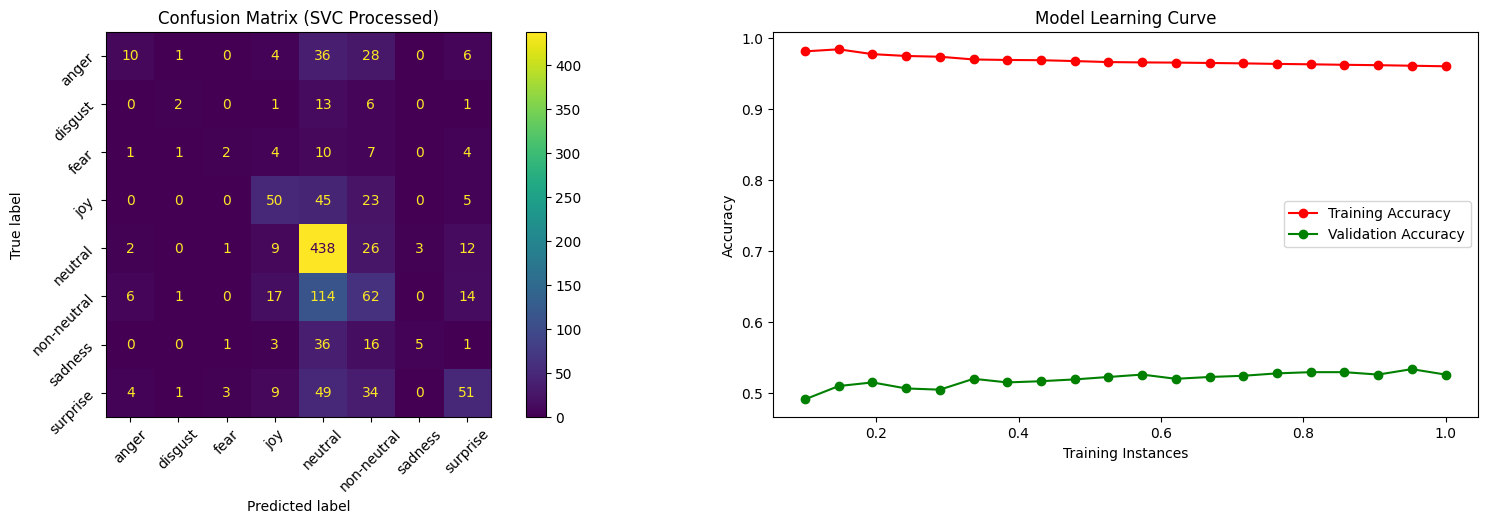

In [30]:
train_sizes = np.linspace(0.1, 1.0, 20)
train_acc_scores, val_acc_scores = [], []

for size in tqdm(train_sizes):
    model = SVC(random_state=42, class_weight=class_weights_processed)

    X_train_subset, y_train_subset = X_train_processed[:int(size * X_train_processed.shape[0])], y_train_processed[:int(size * X_train_processed.shape[0])]
    model.fit(X_train_subset, y_train_subset)

    train_acc_scores.append(accuracy_score(y_train_subset, model.predict(X_train_subset)))
    val_acc_scores.append(accuracy_score(y_val_processed, model.predict(X_val_processed)))

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

cf_disp = ConfusionMatrixDisplay(confusion_matrix(y_val_processed, y_val_pred_processed), display_labels=encoder_processed.classes_)
ax[0].set_title('Confusion Matrix (SVC Processed)')
cf_disp.plot(ax=ax[0])
ax[0].tick_params(labelrotation=45)

ax[1].plot(train_sizes, train_acc_scores, 'o-', color="r", label="Training Accuracy")
ax[1].plot(train_sizes, val_acc_scores, 'o-', color="g", label="Validation Accuracy")
ax[1].set_xlabel("Training Instances")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Model Learning Curve")
ax[1].legend(loc="best")

plt.show()

100%|██████████| 20/20 [03:47<00:00, 11.37s/it]


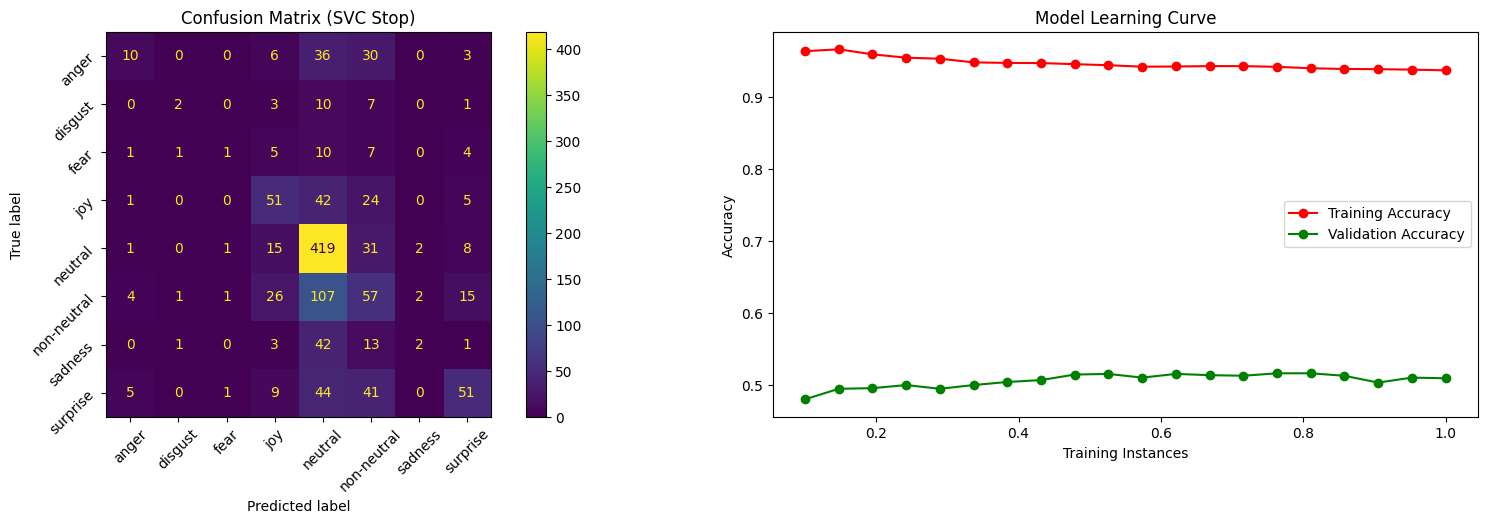

In [31]:
train_sizes = np.linspace(0.1, 1.0, 20)
train_acc_scores, val_acc_scores = [], []

for size in tqdm(train_sizes):
    model = SVC(random_state=42, class_weight=class_weights_stop)

    X_train_subset, y_train_subset = X_train_stop[:int(size * X_train_stop.shape[0])], y_train_stop[:int(size * X_train_stop.shape[0])]
    model.fit(X_train_subset, y_train_subset)

    train_acc_scores.append(accuracy_score(y_train_subset, model.predict(X_train_subset)))
    val_acc_scores.append(accuracy_score(y_val_stop, model.predict(X_val_stop)))

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

cf_disp = ConfusionMatrixDisplay(confusion_matrix(y_val_stop, y_val_pred_stop), display_labels=encoder_stop.classes_)
ax[0].set_title('Confusion Matrix (SVC Stop)')
cf_disp.plot(ax=ax[0])
ax[0].tick_params(labelrotation=45)

ax[1].plot(train_sizes, train_acc_scores, 'o-', color="r", label="Training Accuracy")
ax[1].plot(train_sizes, val_acc_scores, 'o-', color="g", label="Validation Accuracy")
ax[1].set_xlabel("Training Instances")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Model Learning Curve")
ax[1].legend(loc="best")

plt.show()

# K-Means Clustering

## Objective
The objective of this section is to apply K-Means clustering to the text data for pattern discovery and exploration. This involves implementing the K-Means algorithm, correctly determining the optimal number of clusters, and clustering the text data accordingly.

## Algorithm Implementation
1. **Correct Application of K-Means Algorithm:**
   - Implement the K-Means clustering algorithm to cluster the text data.
   - Ensure proper initialization of cluster centroids and convergence criteria.
   - Utilize appropriate distance metrics (e.g., Euclidean distance, cosine similarity) for measuring the similarity between data points.

## Optimal Clusters
2. **Accurate Determination of Number of Clusters:**
   - Determine the optimal number of clusters using appropriate methods such as the elbow method, silhouette score, or gap statistic.
   - Evaluate different numbers of clusters and select the one that maximizes intra-cluster similarity while minimizing inter-cluster dissimilarity.
   - Ensure that the chosen number of clusters effectively captures the underlying structure and patterns present in the text data.


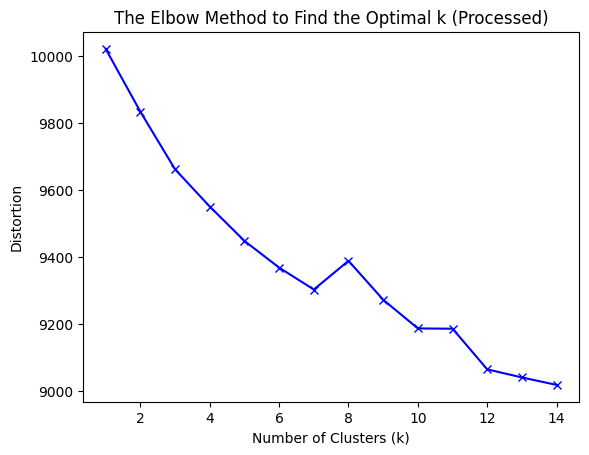

In [32]:
max_num_clusters = 15
distortions = []

for n_clusters in range(1, max_num_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_train_processed)
    distortions.append(kmeans.inertia_)

plt.plot(range(1, max_num_clusters), distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method to Find the Optimal k (Processed)')
plt.show()

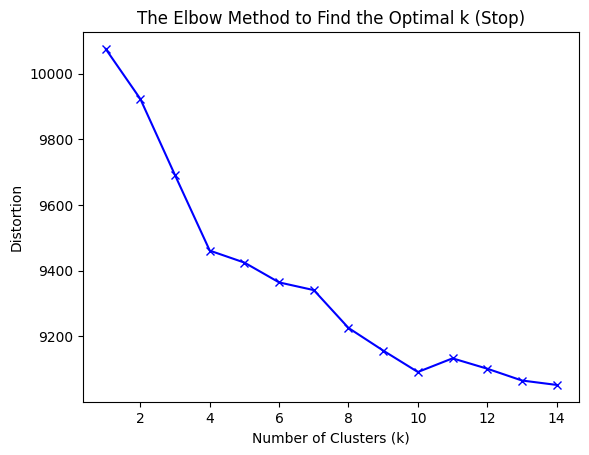

In [33]:
max_num_clusters = 15
distortions = []

for n_clusters in range(1, max_num_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_train_stop)
    distortions.append(kmeans.inertia_)

plt.plot(range(1, max_num_clusters), distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method to Find the Optimal k (Stop)')
plt.show()

In [34]:
processed_optimal_k = 7
stop_optimal_k = 10

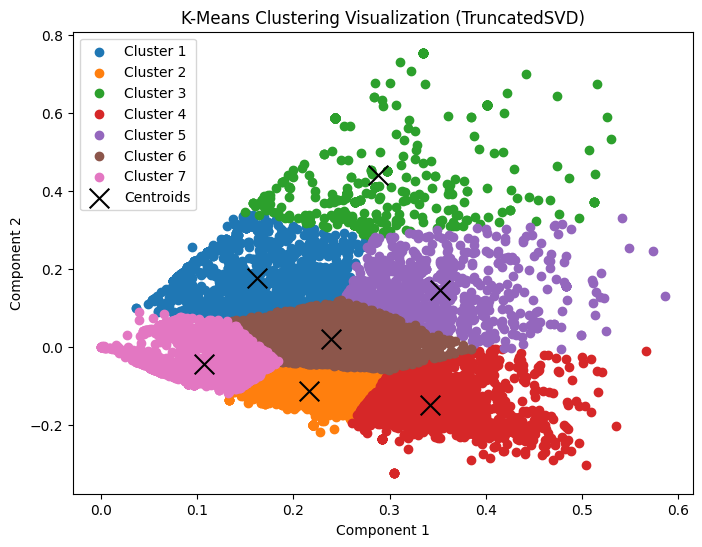

In [35]:
svd_processed = TruncatedSVD(n_components=2, random_state=42)
tfidf_matrix_2d = svd_processed.fit_transform(X_train_processed)

kmeans = KMeans(n_clusters=processed_optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(tfidf_matrix_2d)
cluster_centroids = kmeans.cluster_centers_

plt.figure(figsize=(8, 6))
for i in range(processed_optimal_k):
    cluster_points = tfidf_matrix_2d[cluster_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i + 1}')

plt.scatter(cluster_centroids[:, 0], cluster_centroids[:, 1], marker='x', s=200, c='black', label='Centroids')

plt.title('K-Means Clustering Visualization (TruncatedSVD)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

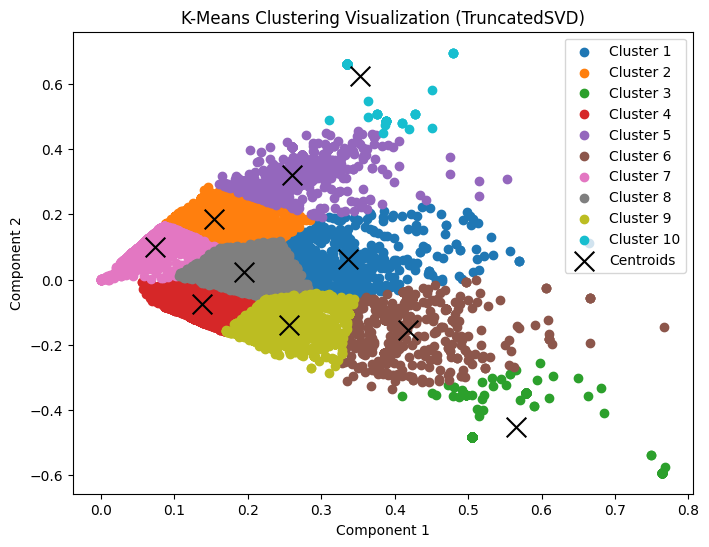

In [36]:
svd_processed = TruncatedSVD(n_components=2, random_state=42)
tfidf_matrix_2d = svd_processed.fit_transform(X_train_stop)

kmeans = KMeans(n_clusters=stop_optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(tfidf_matrix_2d)
cluster_centroids = kmeans.cluster_centers_

plt.figure(figsize=(8, 6))
for i in range(stop_optimal_k):
    cluster_points = tfidf_matrix_2d[cluster_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i + 1}')

plt.scatter(cluster_centroids[:, 0], cluster_centroids[:, 1], marker='x', s=200, c='black', label='Centroids')

plt.title('K-Means Clustering Visualization (TruncatedSVD)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()